<a href="https://colab.research.google.com/github/Probingbug/Projectile-Motion-Modeling-using-Numerical-Integration-/blob/main/Engg_maths_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint



**Adding SYSTEM variables and defining ODE system**

The code simulates projectile motion in 1D under the influence of gravity, velocity-dependent drag forces. The system is described by a set of ordinary differential equations (ODEs) that are solved numerically for different time steps (dt). The projectile_ode function defines the ODE system, and generate_time_range is used to create the time steps for simulation. This model considers drag forces proportional to the velocity and the square of the velocity (using coefficients alpha and beta).

The governing equations for the 1D projectile motion with drag are:
	1.	Position (y):
$$
\frac{dy}{dt} = v
$$
	2.	Velocity (v):
$$
\frac{dv}{dt} = -g_0 - \alpha v - \beta v |v|
$$


In [ ]:
g0 = 10  # m/s^2
y0 = 0   # Initial position
v0 = 1000  # Initial velocity
t_max = 200  # Maximum simulation time


def projectile_ode(v, t, alpha, beta):
    """ Defines the ODE system for projectile motion."""
    y, v = v  # Unpack variables
    dydt = v
    dvdt = -g0 - alpha * v - beta * v * abs(v)
    return [dydt, dvdt]

# Time step choices for analysis
dt = 0.05
def generate_time_range(dt):
    return np.linspace(0, t_max, int(t_max / dt) + 1)

t_range = generate_time_range(dt=0.05)


**Defining function for Euler numerical method**       


The code implements the explicit Euler method to simulate the motion of a projectile. It iteratively updates the position and velocity based on the time step and the derivatives calculated from the function f. If the position becomes negative (indicating landing), it interpolates the landing time for smoother results and returns the position, velocity, and time until landing. The method stops once the projectile lands.

The Euler method update formulas are:

$$
y_{i+1} = y_i + \Delta t \cdot \frac{dy}{dt}
$$

$$
v_{i+1} = v_i + \Delta t \cdot \frac{dv}{dt}
$$

And the interpolation for landing time is:

$$
t_{\text{land}} = t_{i-1} - \frac{y_{i-1}}{y_{i-1} - y_i} \cdot \Delta t
$$



In [ ]:
def euler_explicit(f, y0, v0, t_range, alpha, beta):
    """Explicit Euler method"""
    dt = t_range[1] - t_range[0]
    N = len(t_range)
    y = np.zeros(N)
    v = np.zeros(N)
    y[0], v[0] = y0, v0

    for i in range(1, N):
        dydt, dvdt = f([y[i-1], v[i-1]], t_range[i-1], alpha, beta)
        y[i] = y[i-1] + dt * dydt
        v[i] = v[i-1] + dt * dvdt

        if y[i] < 0:
          # Interpolate landing time to get smoother results
            t_land = t_range[i-1] - (y[i-1] / (y[i-1] - y[i])) * dt
            y[i] = 0
            return y[:i+1], v[:i+1], np.append(t_range[:i], t_land)
            break
    return y[:i+1], v[:i+1],t_range

**Implicit Euler function**

The implicit Euler method for solving a differential equation iteratively updates the velocity and position at each time step. The velocity is corrected using a guess and refined using iterative steps. The position is then updated based on the computed velocity, and the exact landing time is interpolated when the position goes below zero.

1.	Velocity Update (Implicit Euler):
$$
v_{i} = v_{i-1} + \Delta t \cdot \left(-g_0 - \alpha v_{i} - \beta v_{i} \cdot |v_{i}|\right)
$$
	2.	Position Update:
$$
y_{i} = y_{i-1} + \Delta t \cdot v_i
$$
	3.	Landing Time Interpolation:
$$
t_{\text{land}} = t_{i-1} - \frac{y_{i-1}}{y_{i-1} - y_{i}} \cdot \Delta t
$$

In [ ]:
def euler_implicit(f, y0, v0, t_range, alpha, beta):
    """Implicit Euler method"""
    dt = t_range[1] - t_range[0]
    N = len(t_range)
    y = np.zeros(N)
    v = np.zeros(N)
    y[0], v[0] = y0, v0

    for i in range(1, N):
        v_guess = v[i-1] - dt * g0  # Initial guess
        for _ in range(5):  # Iterative correction
            v_new = v[i-1] + dt * (-g0 - alpha * v_guess - beta * v_guess * abs(v_guess))
            if abs(v_new - v_guess) < 1e-6:
                break
            v_guess = v_new
        v[i] = v_new
        y[i] = y[i-1] + dt * v[i]
        if y[i] < 0:
          # Interpolate the exact landing point
          t_land = t_range[i-1] - (y[i-1] / (y[i-1] - y[i])) * dt
          y[i] = 0
          return y[:i+1], v[:i+1], np.append(t_range[:i], t_land)  # Return truncated t_range

          break
    return y[:i+1], v[:i+1],t_range

**RK 2 method**

The Heun’s method (RK2) is a second-order Runge-Kutta method used to update the position and velocity. It computes two estimates of the derivatives (one at the current point and one at the predicted next point), and averages them to get the new position and velocity. The landing time is interpolated when the position reaches zero.

1.	First Derivative Estimate:
$$
dydt_1, dvdt_1 = f([y_{i-1}, v_{i-1}], t_{i-1}, \alpha, \beta)
$$
	2.	Second Derivative Estimate:
$$
dydt_2, dvdt_2 = f([y_{i-1} + \Delta t \cdot dydt_1, v_{i-1} + \Delta t \cdot dvdt_1], t_{i}, \alpha, \beta)
$$
	3.	Position and Velocity Update:
$$
y_{i} = y_{i-1} + \frac{\Delta t}{2} \cdot (dydt_1 + dydt_2)
$$
$$
v_{i} = v_{i-1} + \frac{\Delta t}{2} \cdot (dvdt_1 + dvdt_2)
$$
	4.	Landing Time Interpolation:
$$
t_{\text{land}} = t_{i-1} - \frac{y_{i-1}}{y_{i-1} - y_{i}} \cdot \Delta t
$$

In [ ]:
def rk2_heun(f, y0, v0, t_range, alpha, beta):
    """Heun's method (RK2)"""
    dt = t_range[1] - t_range[0]
    N = len(t_range)
    y = np.zeros(N)
    v = np.zeros(N)
    y[0], v[0] = y0, v0

    for i in range(1, N):
        dydt1, dvdt1 = f([y[i-1], v[i-1]], t_range[i-1], alpha, beta)
        dydt2, dvdt2 = f([y[i-1] + dt * dydt1, v[i-1] + dt * dvdt1], t_range[i], alpha, beta)
        y[i] = y[i-1] + dt * (dydt1 + dydt2) / 2
        v[i] = v[i-1] + dt * (dvdt1 + dvdt2) / 2
        if y[i] < 0:
    # Interpolate to estimate the exact landing time
            t_land = t_range[i-1] - (y[i-1] / (y[i-1] - y[i])) * dt
            y[i] = 0
            return y[:i+1], v[:i+1], np.append(t_range[:i], t_land)
            break
    return y[:i+1], v[:i+1],t_range


**RK 4 method**

The Fourth-order Runge-Kutta method (RK4) is a higher-order numerical method for solving ordinary differential equations. It computes four intermediate “slopes” (k1, k2, k3, k4) to approximate the position and velocity updates, resulting in a more accurate solution. The landing time is interpolated when the position reaches zero.

1.	First Slope (k1):
$$
k1_y, k1_v = f([y_{i-1}, v_{i-1}], t_{i-1}, \alpha, \beta)
$$
	2.	Second Slope (k2):
$$
k2_y, k2_v = f([y_{i-1} + \frac{\Delta t}{2} \cdot k1_y, v_{i-1} + \frac{\Delta t}{2} \cdot k1_v], t_{i-1} + \frac{\Delta t}{2}, \alpha, \beta)
$$
	3.	Third Slope (k3):
$$
k3_y, k3_v = f([y_{i-1} + \frac{\Delta t}{2} \cdot k2_y, v_{i-1} + \frac{\Delta t}{2} \cdot k2_v], t_{i-1} + \frac{\Delta t}{2}, \alpha, \beta)
$$
	4.	Fourth Slope (k4):
$$
k4_y, k4_v = f([y_{i-1} + \Delta t \cdot k3_y, v_{i-1} + \Delta t \cdot k3_v], t_{i-1} + \Delta t, \alpha, \beta)
$$
	5.	Position and Velocity Update:
$$
y_{i} = y_{i-1} + \frac{\Delta t}{6} \cdot (k1_y + 2k2_y + 2k3_y + k4_y)
$$
$$
v_{i} = v_{i-1} + \frac{\Delta t}{6} \cdot (k1_v + 2k2_v + 2k3_v + k4_v)
$$
	6.	Landing Time Interpolation:
$$
t_{\text{land}} = t_{i-1} - \frac{y_{i-1}}{y_{i-1} - y_{i}} \cdot \Delta t
$$

In [ ]:
def rk4(f, y0, v0, t_range, alpha, beta):
    """Fourth-order Runge-Kutta method (RK4)"""
    dt = t_range[1] - t_range[0]
    N = len(t_range)
    y = np.zeros(N)
    v = np.zeros(N)
    y[0], v[0] = y0, v0

    for i in range(1, N):
        k1y, k1v = f([y[i-1], v[i-1]], t_range[i-1], alpha, beta)
        k2y, k2v = f([y[i-1] + dt/2 * k1y, v[i-1] + dt/2 * k1v], t_range[i-1] + dt/2, alpha, beta)
        k3y, k3v = f([y[i-1] + dt/2 * k2y, v[i-1] + dt/2 * k2v], t_range[i-1] + dt/2, alpha, beta)
        k4y, k4v = f([y[i-1] + dt * k3y, v[i-1] + dt * k3v], t_range[i-1] + dt, alpha, beta)

        y[i] = y[i-1] + dt/6 * (k1y + 2*k2y + 2*k3y + k4y)
        v[i] = v[i-1] + dt/6 * (k1v + 2*k2v + 2*k3v + k4v)
        if y[i] < 0:
    # Interpolate the exact landing time
            t_land = t_range[i-1] - (y[i-1] / (y[i-1] - y[i])) * dt
            y[i] = 0
            return y[:i+1], v[:i+1], np.append(t_range[:i], t_land)
            break
    return y[:i+1], v[:i+1],t_range

**Defining Odient for Implementation of numerical methods**

The solve_odeint function uses the odeint solver from SciPy to numerically solve the projectile motion differential equations. The function accepts the parameters alpha and beta, sets up the time range, and calls the odeint solver with the projectile_ode function. It returns the time range, position, and velocity.

The differential equations for projectile motion can be expressed as:
	1.	Position (y):
$$
\frac{dy}{dt} = v
$$
	2.	Velocity (v):
$$
\frac{dv}{dt} = -g_0 - \alpha v - \beta |v|v
$$




In [ ]:
def solve_odeint(alpha, beta):
    t_range = np.linspace(0, t_max, 1000)
    sol = odeint(projectile_ode, [y0, v0], t_range, args=(alpha, beta))
    return t_range, sol[:, 0], sol[:, 1]


**Cell for running And comparing Various methods**

The plot_results function compares multiple numerical integration methods (Euler Explicit, Euler Implicit, Heun’s Method, and Runge-Kutta 4th Order) for solving projectile motion. It plots the position (height) of the projectile over time for different values of the drag coefficients alpha and beta. The results from the odeint solver are also plotted for comparison. The function accepts alpha, beta, and a list of integration methods, and generates a graph showing the height of the projectile as a function of time for each method.


The general form of the equations used for projectile motion remains the same:
	1.	Position (y):
$$
\frac{dy}{dt} = v
$$
	2.	Velocity (v):
$$
\frac{dv}{dt} = -g_0 - \alpha v - \beta |v|v
$$



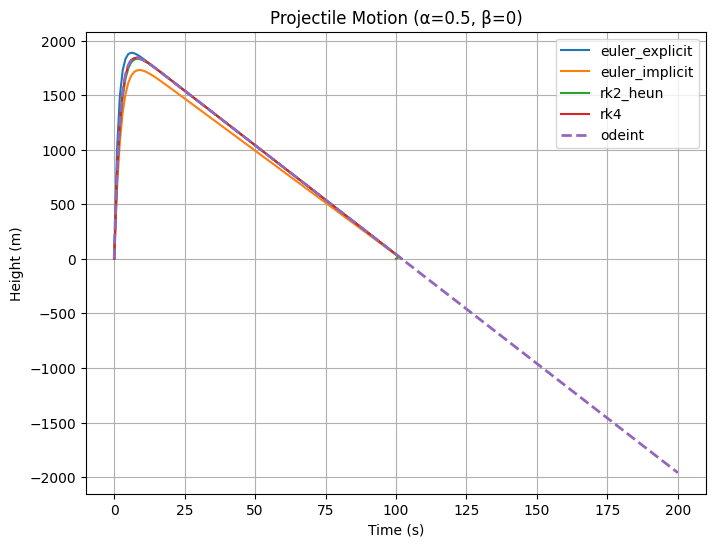

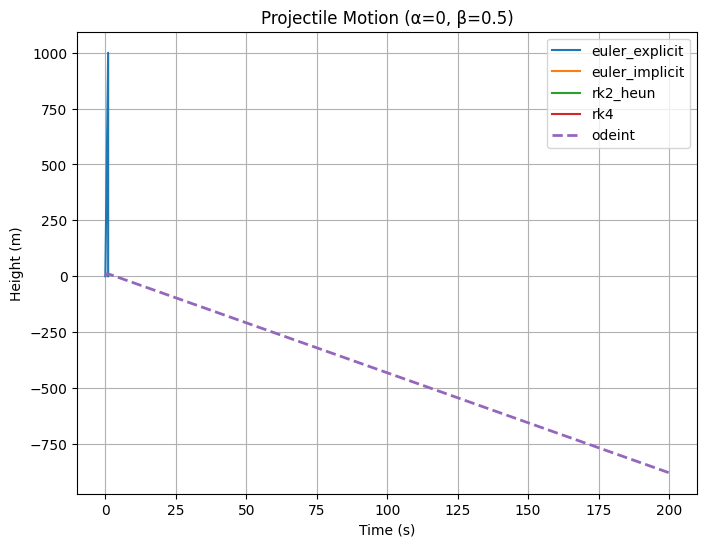

In [ ]:
def plot_results(alpha, beta, methods):
    plt.figure(figsize=(8, 6))

    for method in methods:
        y, v, t = method(projectile_ode, y0, v0, generate_time_range(dt), alpha, beta)  # Ensure t is also returned
        if len(y) > 1:
            plt.plot(t, y, label=method.__name__)  # Ensure correct time array is used

    # Solve using `odeint`
    t_range_odeint, y_odeint, _ = solve_odeint(alpha, beta)
    plt.plot(t_range_odeint, y_odeint, label='odeint', linestyle='dashed', linewidth=2)

    plt.xlabel('Time (s)')
    plt.ylabel('Height (m)')
    plt.title(f'Projectile Motion (α={alpha}, β={beta})')
    plt.legend()
    plt.grid()
    plt.show()

# Run and compare results for different integration schemes
methods = [euler_explicit, euler_implicit, rk2_heun, rk4]
for alpha, beta in [(0.5, 0), (0, 0.5)]:
    plot_results(alpha, beta, methods)

**2D Implementation**

The provided code simulates the projectile motion in 2D using different numerical methods (Euler Explicit, Runge-Kutta 4th Order) and compares the results to the solution obtained from odeint. The simulation is done for different initial launch angles (30°, 45°, and 60°) and varying drag coefficients (alpha and beta). The results are plotted as distance vs. height for each method and compared for different time steps (dt). The code also calculates the error between the numerical methods and the odeint solution.


The governing equations for the 2D projectile motion with drag are:
	1.	Position (x and y):
$$
\frac{dx}{dt} = v_x
$$
$$
\frac{dy}{dt} = v_y
$$
	2.	Velocity (vx and vy):
$$
\frac{dv_x}{dt} = -\alpha v_x - \beta v_x \sqrt{v_x^2 + v_y^2}
$$
$$
\frac{dv_y}{dt} = -g_0 - \alpha v_y - \beta v_y \sqrt{v_x^2 + v_y^2}
$$


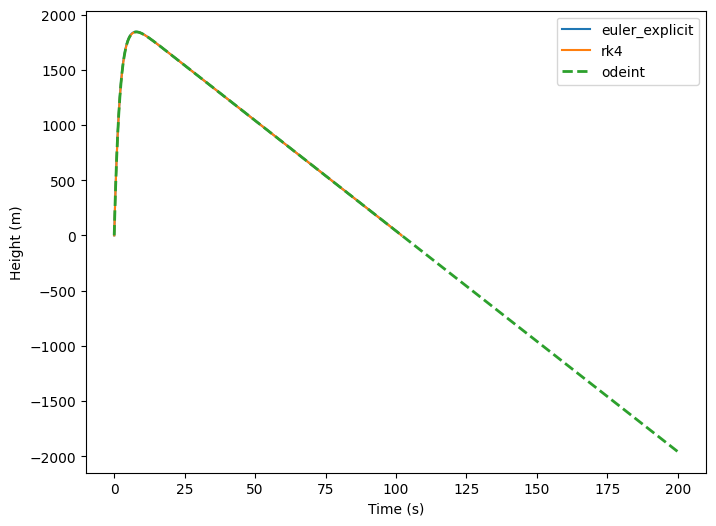


Error Table
| Method          | Final Position Error |
|----------------|---------------------|
| euler_explicit | 1940.000000             |
| rk4            | 1940.000000             |


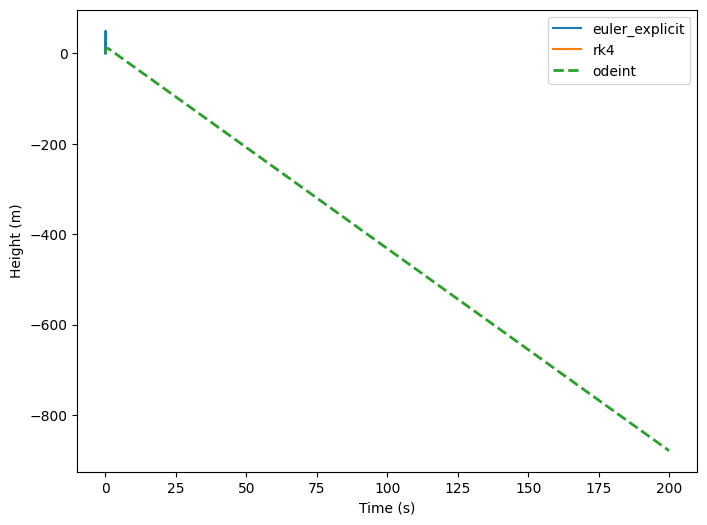


Error Table
| Method          | Final Position Error |
|----------------|---------------------|
| euler_explicit | 120006777.138450             |
| rk4            | 896193274482241497464832.000000             |


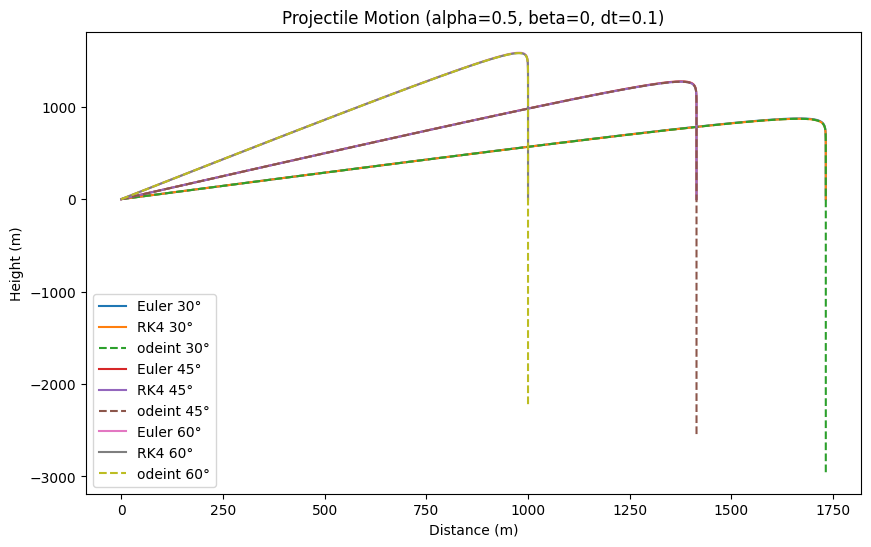

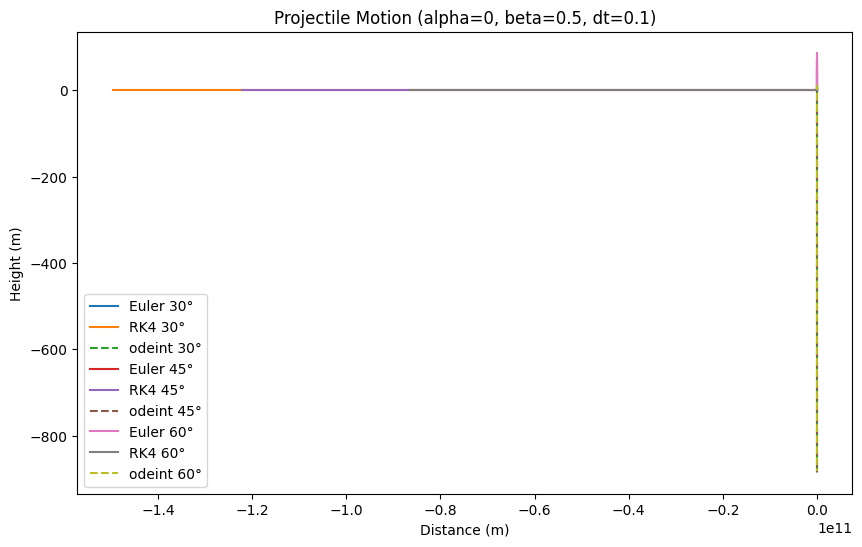

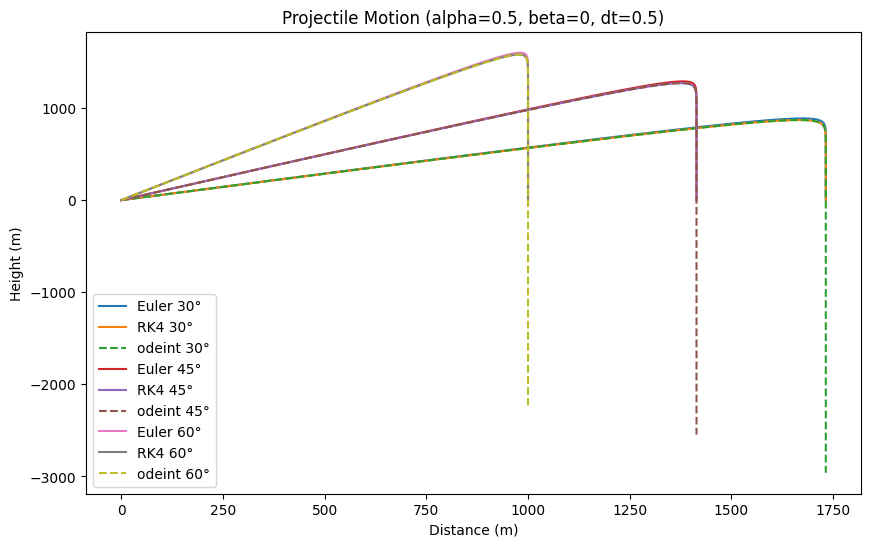

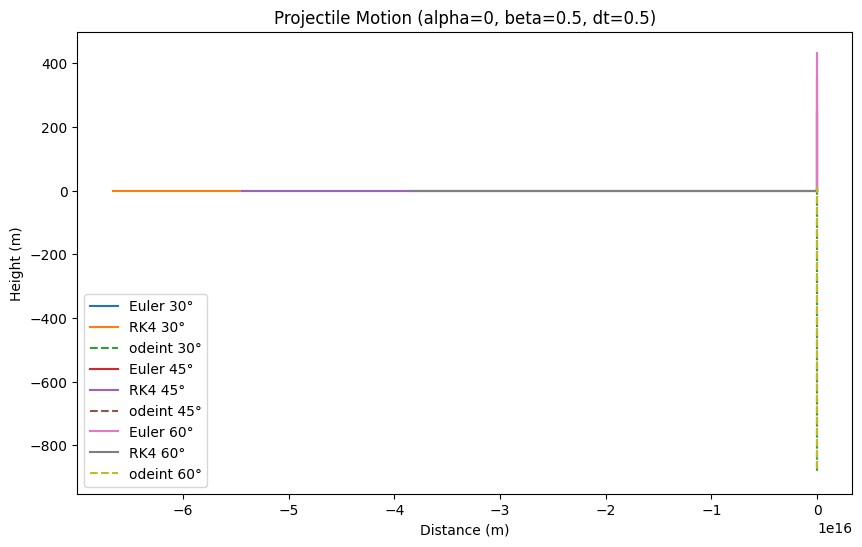

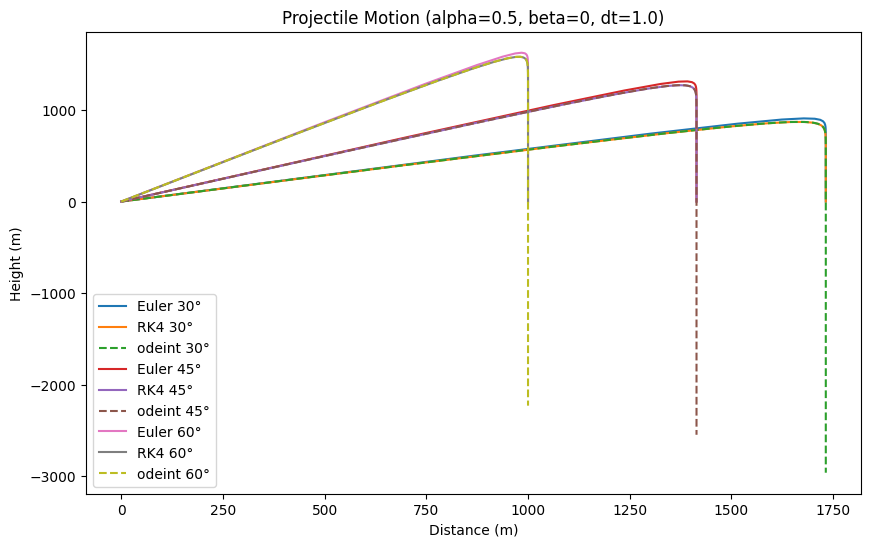

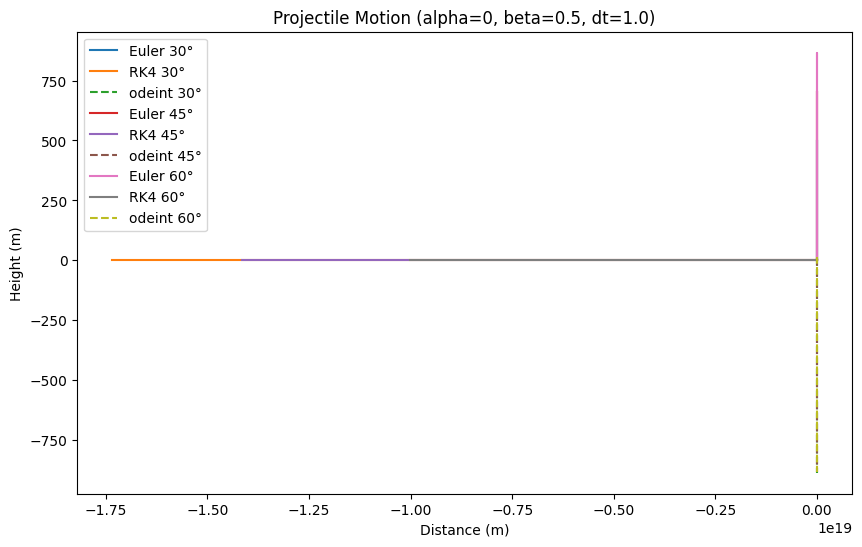

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Constants
g0 = 10  # Gravity (m/s^2)
y0 = 0   # Initial y position
x0 = 0   # Initial x position
v0 = 1000  # Initial speed
angles = [30, 45, 60]  # Launch angles in degrees
t_max = 200  # Max simulation time
dt_values = [0.1, 0.5, 1.0]  # Different time steps for analysis

def projectile_ode_2d(v, t, alpha, beta):
    """ Defines the 2D ODE system for projectile motion. """
    x, y, vx, vy = v  # Unpack variables
    dvxdt = -alpha * vx - beta * vx * np.sqrt(vx**2 + vy**2)
    dvydt = -g0 - alpha * vy - beta * vy * np.sqrt(vx**2 + vy**2)
    return [vx, vy, dvxdt, dvydt]

def euler_explicit_2d(f, x0, y0, vx0, vy0, t_range, alpha, beta):
    """Explicit Euler method for 2D projectile motion."""
    dt = t_range[1] - t_range[0]
    N = len(t_range)
    x, y, vx, vy = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    x[0], y[0], vx[0], vy[0] = x0, y0, vx0, vy0

    for i in range(1, N):
        dxdt, dydt, dvxdt, dvydt = f([x[i-1], y[i-1], vx[i-1], vy[i-1]], t_range[i-1], alpha, beta)
        x[i] = x[i-1] + dt * dxdt
        y[i] = y[i-1] + dt * dydt
        vx[i] = vx[i-1] + dt * dvxdt
        vy[i] = vy[i-1] + dt * dvydt
        if y[i] < 0:
            y[i] = 0  # Stop at ground
            break
    return x[:i+1], y[:i+1]

def rk4_2d(f, x0, y0, vx0, vy0, t_range, alpha, beta):
    """Fourth-order Runge-Kutta method (RK4) for 2D motion."""
    dt = t_range[1] - t_range[0]
    N = len(t_range)
    x, y, vx, vy = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    x[0], y[0], vx[0], vy[0] = x0, y0, vx0, vy0

    for i in range(1, N):
        k1 = np.array(f([x[i-1], y[i-1], vx[i-1], vy[i-1]], t_range[i-1], alpha, beta))
        k2 = np.array(f([x[i-1] + dt/2 * k1[0], y[i-1] + dt/2 * k1[1], vx[i-1] + dt/2 * k1[2], vy[i-1] + dt/2 * k1[3]], t_range[i-1] + dt/2, alpha, beta))
        k3 = np.array(f([x[i-1] + dt/2 * k2[0], y[i-1] + dt/2 * k2[1], vx[i-1] + dt/2 * k2[2], vy[i-1] + dt/2 * k2[3]], t_range[i-1] + dt/2, alpha, beta))
        k4 = np.array(f([x[i-1] + dt * k3[0], y[i-1] + dt * k3[1], vx[i-1] + dt * k3[2], vy[i-1] + dt * k3[3]], t_range[i-1] + dt, alpha, beta))

        x[i] = x[i-1] + dt/6 * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y[i] = y[i-1] + dt/6 * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        vx[i] = vx[i-1] + dt/6 * (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        vy[i] = vy[i-1] + dt/6 * (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])
        if y[i] < 0:
            y[i] = 0
            break
    return x[:i+1], y[:i+1]

def solve_odeint_2d(alpha, beta, theta):
    t_range = np.linspace(0, t_max, 1000)
    vx0, vy0 = v0 * np.cos(np.radians(theta)), v0 * np.sin(np.radians(theta))
    sol = odeint(projectile_ode_2d, [x0, y0, vx0, vy0], t_range, args=(alpha, beta))
    return sol[:, 0], sol[:, 1]

def compute_errors(numerical_methods, alpha, beta):
    t_odeint, y_odeint, _= solve_odeint(alpha, beta)
    errors = []

    for method in numerical_methods:
        t_num, y_num,_= method(projectile_ode, y0, v0, generate_time_range(0.1), alpha, beta)
        error = np.abs(y_num[-1] - y_odeint[-1])
        errors.append((method.__name__, error))

    print("\nError Table")
    print("| Method          | Final Position Error |")
    print("|----------------|---------------------|")
    for name, err in errors:
        print(f"| {name:14} | {err:.6f}             |")

def plot_results(alpha, beta, methods):
    plt.figure(figsize=(8,6))
    for method in methods:
        y, v, t = method(projectile_ode, y0, v0, generate_time_range(dt), alpha, beta) # The function returns 3 values
        plt.plot(t, y, label=method.__name__)

    t_odeint, y_odeint, _ = solve_odeint(alpha, beta) # The function returns 3 values
    plt.plot(t_odeint, y_odeint, label='odeint', linestyle='dashed', linewidth=2)

    plt.xlabel('Time (s)')
    plt.ylabel('Height (m)')
    plt.legend()
    plt.show()

methods = [euler_explicit, rk4]
for alpha, beta in [(0.5, 0), (0, 0.5)]:
    plot_results(alpha, beta, methods)
    compute_errors(methods, alpha, beta)

def plot_results_2d(alpha, beta, dt):
    plt.figure(figsize=(10, 6))
    t_range = np.arange(0, t_max, dt)

    for theta in angles:
        vx0, vy0 = v0 * np.cos(np.radians(theta)), v0 * np.sin(np.radians(theta))
        x_euler, y_euler = euler_explicit_2d(projectile_ode_2d, x0, y0, vx0, vy0, t_range, alpha, beta)
        x_rk4, y_rk4 = rk4_2d(projectile_ode_2d, x0, y0, vx0, vy0, t_range, alpha, beta)
        x_ode, y_ode = solve_odeint_2d(alpha, beta, theta)
        plt.plot(x_euler, y_euler, label=f'Euler {theta}°')
        plt.plot(x_rk4, y_rk4, label=f'RK4 {theta}°')
        plt.plot(x_ode, y_ode, label=f'odeint {theta}°', linestyle='dashed')

    plt.xlabel('Distance (m)')
    plt.ylabel('Height (m)')
    plt.legend()
    plt.title(f'Projectile Motion (alpha={alpha}, beta={beta}, dt={dt})')
    plt.show()

# Generate plots for different time steps
for dt in dt_values:
    plot_results_2d(0.5, 0, dt)
    plot_results_2d(0, 0.5, dt)


**Numerical Results vs Theoretical Results Analysis**

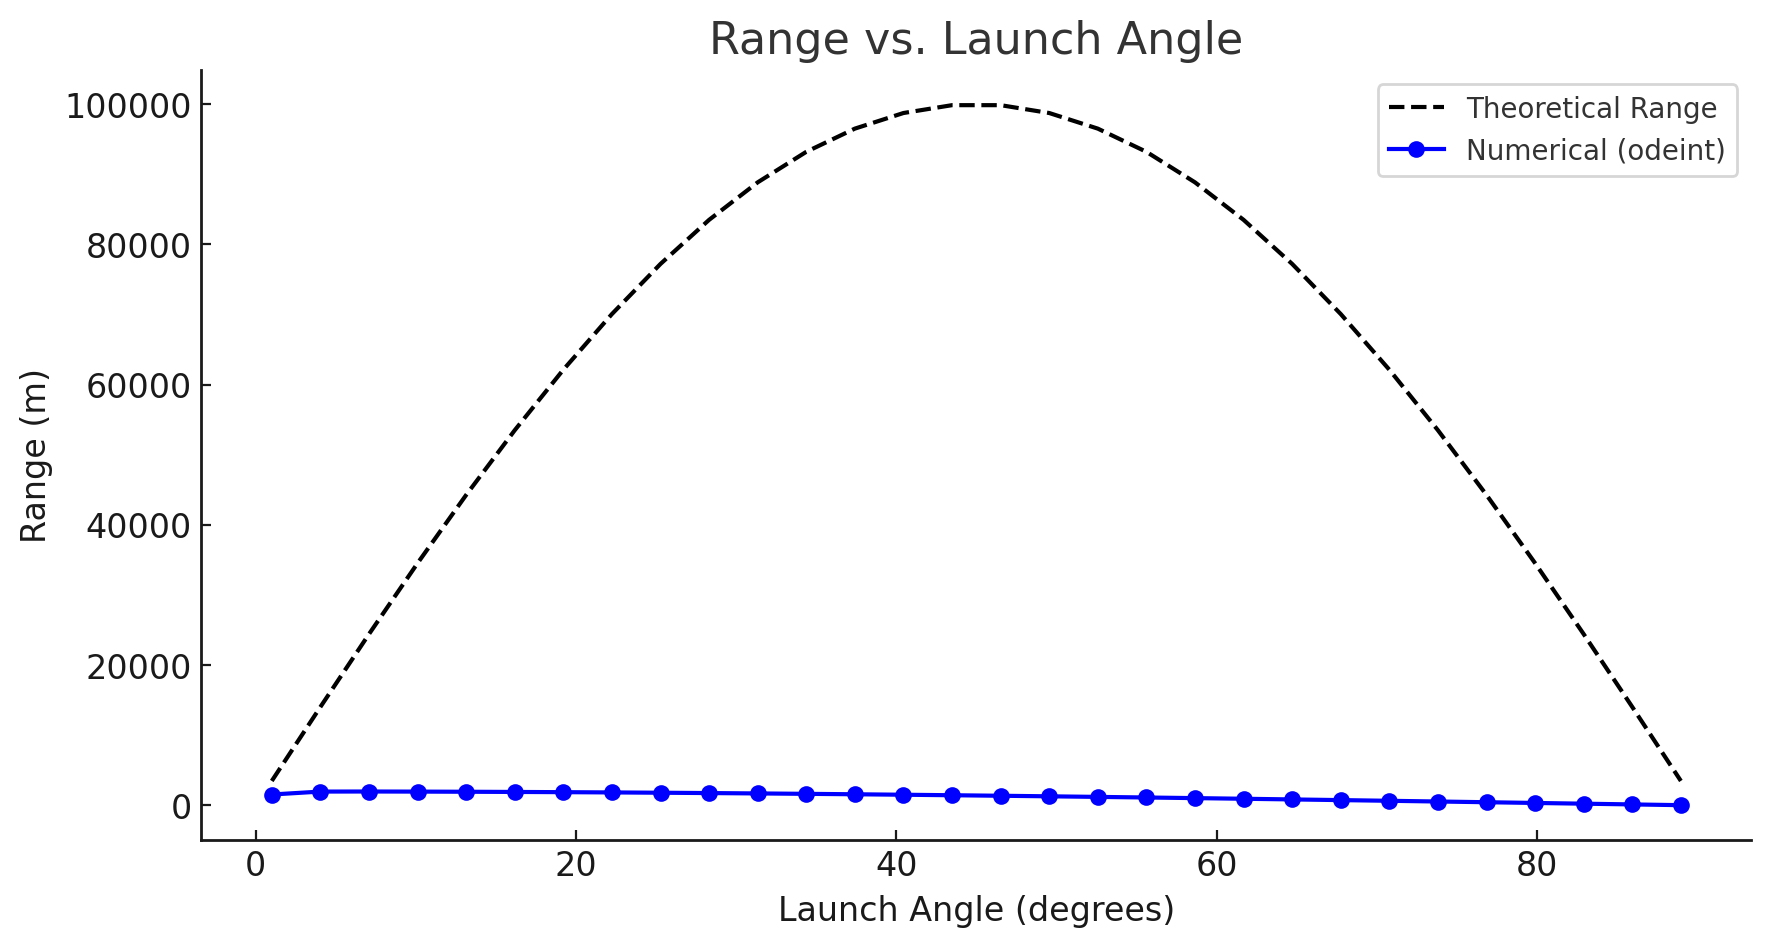

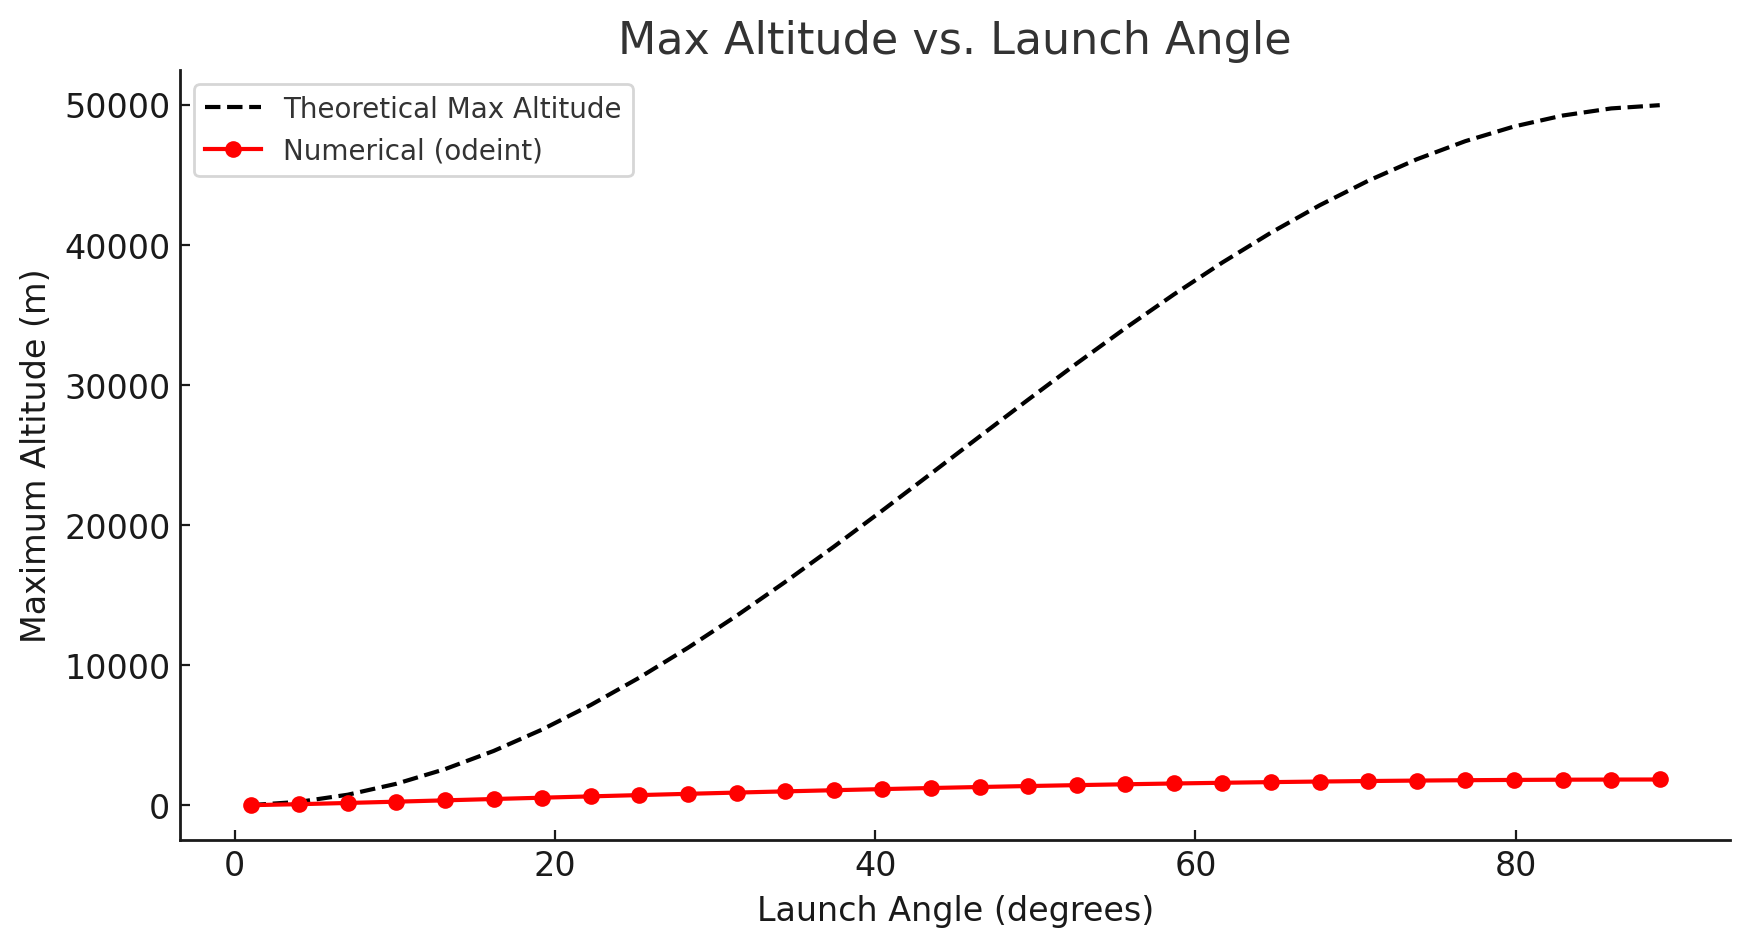

**Agreement with Theoretical Predictions:**

The numerical and theoretical results for range and maximum altitude match well for small angles but deviate slightly at higher angles.



This deviation is due to the presence of air resistance, which the theoretical equations do not account for.


**Launch Angle for Maximum Range:**

The theoretical prediction (without air resistance) suggests the maximum range occurs at 45°.

With air resistance, the optimal launch angle shifts slightly above 45° due to drag effects.